# Correlation of Envelope with activations 

We will correlate envelope in several filterbands with activations in several layers of the deep 5 net. We will use a dataset known to have informative high frequency oscillations.

In [3]:
import logging
import theano.tensor as T
import lasagne
import logging
log = logging.getLogger()
log.setLevel("DEBUG")
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'png' 

import matplotlib.lines as mlines
import seaborn
seaborn.set_style('darkgrid')
matplotlib.rcParams['figure.figsize'] = (16.0, 1.0)
matplotlib.rcParams['font.size'] = 7
from braindecode.scripts.print_results import ResultPrinter
import theano
import scipy.signal
import numpy as np

## Load dataset(s)

In [5]:
from braindecode.datasets.combined import CombinedSet
from braindecode.datasets.cnt_signal_matrix import CntSignalMatrix
from braindecode.datasets.loaders import BBCIDataset
from braindecode.mywyrm.processing import (resample_cnt,
    exponential_standardize_cnt, common_average_reference_cnt)
from braindecode.datasets.sensor_positions import get_C_sensors_sorted

from braindecode.datasets.signal_processor import SignalProcessor

signal_processor = SignalProcessor(
    set_loader=BBCIDataset(
        filename="data/BBCI-without-last-runs/BhNoMoSc1S001R01_ds10_1-12.BBCI.mat",
        load_sensor_names=get_C_sensors_sorted()),
    segment_ival=[1500, 4000], 
    cnt_preprocessors=[[resample_cnt,dict(newfs=250)],
                       [exponential_standardize_cnt, dict()],
                       [common_average_reference_cnt, dict()]],
    marker_def={'1 - Right': [1], '2 - Left': [2], '3 - Rest': [3], '4 - Feet':[4]},
   )

raw_set_train = CntSignalMatrix(signal_processor, sensor_names=get_C_sensors_sorted())


signal_processor_test = SignalProcessor(
    set_loader=BBCIDataset(
            filename="data/BBCI-only-last-runs/BhNoMoSc1S001R13_ds10_1-2BBCI.mat",
    load_sensor_names=get_C_sensors_sorted()),
    segment_ival=[1500, 4000], 
    cnt_preprocessors=[[resample_cnt,dict(newfs=250)],
                       [exponential_standardize_cnt, dict()],
                       [common_average_reference_cnt, dict()]],
    marker_def={'1 - Right': [1], '2 - Left': [2], '3 - Rest': [3], '4 - Feet':[4]},
    )

raw_set_test = CntSignalMatrix(signal_processor_test, sensor_names=get_C_sensors_sorted())

combined_set = CombinedSet(sets=[raw_set_train, raw_set_test])
combined_set.load()

INFO:braindecode.datasets.cnt_signal_matrix:Load continuous signal...
INFO:braindecode.datasets.cnt_signal_matrix:Preprocess continuous signal...
INFO:braindecode.datasets.cnt_signal_matrix:Loaded dataset with shape: (1725659, 45, 1, 1)
INFO:braindecode.datasets.cnt_signal_matrix:Load continuous signal...
INFO:braindecode.datasets.cnt_signal_matrix:Preprocess continuous signal...
INFO:braindecode.datasets.cnt_signal_matrix:Loaded dataset with shape: (308544, 45, 1, 1)


## Create model function

In [6]:
from braindecode.veganlasagne.layers import FinalReshapeLayer, StrideReshapeLayer, get_n_sample_preds
from lasagne.layers.pool import Pool2DLayer
from braindecode.veganlasagne.batch_norm import BatchNormLayer
from lasagne.layers import InputLayer, DimshuffleLayer, DropoutLayer, NonlinearityLayer, Conv2DLayer
from lasagne.nonlinearities import identity, elu, softmax
input_time_length = 750

def get_deep_5_net(input_time_length):
    n_sensors = len(get_C_sensors_sorted())
    n_classes = 4
    network = InputLayer([None,n_sensors,input_time_length,1])
    network = DimshuffleLayer(network, [0,3,2,1])
    network = DropoutLayer(network, p=0.5)
    network = Conv2DLayer(network, num_filters=25, filter_size=[10,1], nonlinearity=identity, name='time_conv')
    network = Conv2DLayer(network, num_filters=25,filter_size=[1,n_sensors], nonlinearity=identity, name='spat_conv')
    network = BatchNormLayer(network, epsilon=1e-4, alpha=0.1, nonlinearity=elu)
    network = Pool2DLayer(network, pool_size=(3,1), stride=(1,1), mode='max')
    network = StrideReshapeLayer(network, n_stride=3)
    network = DropoutLayer(network, p=0.5)
    network = Conv2DLayer(network, num_filters=50, filter_size=[10,1], nonlinearity=identity, name='conv_2')
    network = BatchNormLayer(network, epsilon=1e-4, alpha=0.1, nonlinearity=elu)
    network = Pool2DLayer(network, pool_size=(3,1), stride=(1,1), mode='max')
    network = StrideReshapeLayer(network, n_stride=3)
    network = DropoutLayer(network, p=0.5)
    network = Conv2DLayer(network, num_filters=50, filter_size=[10,1], nonlinearity=identity, name='conv_3')
    network = BatchNormLayer(network, epsilon=1e-4, alpha=0.1, nonlinearity=elu)
    network = Pool2DLayer(network, pool_size=(3,1), stride=(1,1), mode='max')
    network = StrideReshapeLayer(network, n_stride=3)
    network = DropoutLayer(network, p=0.5)
    network = Conv2DLayer(network, num_filters=50, filter_size=[10,1], nonlinearity=identity, name='conv_4')
    network = BatchNormLayer(network, epsilon=1e-4, alpha=0.1, nonlinearity=elu)
    network = Pool2DLayer(network, pool_size=(3,1), stride=(1,1), mode='max')
    network = StrideReshapeLayer(network, n_stride=3)
    network = DropoutLayer(network, p=0.5)
    network = Conv2DLayer(network, num_filters=n_classes, filter_size=[2,1], nonlinearity=identity, name='final_conv')
    network = FinalReshapeLayer(network)
    network = NonlinearityLayer(network, nonlinearity=softmax)
    return network



## Create and run experiment - only run for 20 epochs, do not run after early stop

In [7]:
from braindecode.datahandling.splitters import SeveralSetsSplitter
from braindecode.datahandling.batch_iteration import CntWindowTrialIterator
from braindecode.veganlasagne.objectives import categorical_crossentropy, sum_of_losses, tied_neighbours_cnt_model
from braindecode.util import FuncAndArgs
from lasagne.updates import adam
from braindecode.veganlasagne.update_modifiers import MaxNormConstraint
from braindecode.veganlasagne.monitors import RuntimeMonitor, CntTrialMisclassMonitor, MisclassMonitor, LossMonitor
from braindecode.veganlasagne.stopping import MaxEpochs
from braindecode.experiments.experiment import Experiment
model = get_deep_5_net(input_time_length)
splitter = SeveralSetsSplitter()
preprocessor = None
n_sample_preds = get_n_sample_preds(model)
iterator = CntWindowTrialIterator(batch_size=50,input_time_length=input_time_length,n_sample_preds=n_sample_preds)
loss_expression = FuncAndArgs(sum_of_losses, loss_expressions=(categorical_crossentropy, tied_neighbours_cnt_model))

updates_expression = adam
updates_modifier = MaxNormConstraint(layer_names_to_norms=dict(time_conv=2.0, spat_conv=2.0,
                                                              conv_2=2.0, conv_3=2.0, conv_4=2.0, final_conv=0.5))
monitors = [LossMonitor(), MisclassMonitor(chan_name='sample_misclass'), 
            CntTrialMisclassMonitor(input_time_length=input_time_length), RuntimeMonitor()]

stop_criterion = MaxEpochs(20)


exp = Experiment(model,combined_set,splitter,preprocessor,iterator,
                loss_expression,updates_expression,updates_modifier,
                monitors, stop_criterion, remember_best_chan='valid_misclass', run_after_early_stop=False)



In [8]:
exp.setup()

INFO:braindecode.experiments.experiment:Layers...
INFO:braindecode.experiments.experiment:InputLayer
INFO:braindecode.experiments.experiment:[None, 45, 750, 1]
INFO:braindecode.experiments.experiment:DimshuffleLayer
INFO:braindecode.experiments.experiment:(None, 1, 750, 45)
INFO:braindecode.experiments.experiment:DropoutLayer
INFO:braindecode.experiments.experiment:(None, 1, 750, 45)
INFO:braindecode.experiments.experiment:Conv2DLayer
INFO:braindecode.experiments.experiment:(None, 25, 741, 45)
INFO:braindecode.experiments.experiment:Conv2DLayer
INFO:braindecode.experiments.experiment:(None, 25, 741, 1)
INFO:braindecode.experiments.experiment:BatchNormLayer
INFO:braindecode.experiments.experiment:(None, 25, 741, 1)
INFO:braindecode.experiments.experiment:Pool2DLayer
INFO:braindecode.experiments.experiment:(None, 25, 739, 1)
INFO:braindecode.experiments.experiment:StrideReshapeLayer
INFO:braindecode.experiments.experiment:(None, 25, 247, 1)
INFO:braindecode.experiments.experiment:Dropout

In [9]:
exp.run()

INFO:braindecode.experiments.experiment:Run until first stop...
INFO:braindecode.experiments.experiment:Split/Preprocess datasets...
INFO:braindecode.experiments.experiment:...Done
INFO:braindecode.experiments.experiment:Epoch 0
INFO:braindecode.experiments.experiment:train_loss                2.74862
INFO:braindecode.experiments.experiment:valid_loss                2.73786
INFO:braindecode.experiments.experiment:test_loss                 2.74659
INFO:braindecode.experiments.experiment:train_sample_misclass     0.74505
INFO:braindecode.experiments.experiment:valid_sample_misclass     0.74537
INFO:braindecode.experiments.experiment:test_sample_misclass      0.74554
INFO:braindecode.experiments.experiment:train_misclass            0.75186
INFO:braindecode.experiments.experiment:valid_misclass            0.75556
INFO:braindecode.experiments.experiment:test_misclass             0.75000
INFO:braindecode.experiments.experiment:runtime                   0.00000
INFO:braindecode.experiments.ex

## See model layers

In [10]:
from braindecode.veganlasagne.layers import print_layers
print_layers(model)

 0 InputLayer                [None, 45, 750, 1]
 1 DimshuffleLayer           (None, 1, 750, 45)
 2 DropoutLayer              (None, 1, 750, 45)
 3 Conv2DLayer               (None, 25, 741, 45)
 4 Conv2DLayer               (None, 25, 741, 1)
 5 BatchNormLayer            (None, 25, 741, 1)
 6 Pool2DLayer               (None, 25, 739, 1)
 7 StrideReshapeLayer        (None, 25, 247, 1)
 8 DropoutLayer              (None, 25, 247, 1)
 9 Conv2DLayer               (None, 50, 238, 1)
10 BatchNormLayer            (None, 50, 238, 1)
11 Pool2DLayer               (None, 50, 236, 1)
12 StrideReshapeLayer        (None, 50, 79, 1)
13 DropoutLayer              (None, 50, 79, 1)
14 Conv2DLayer               (None, 50, 70, 1)
15 BatchNormLayer            (None, 50, 70, 1)
16 Pool2DLayer               (None, 50, 68, 1)
17 StrideReshapeLayer        (None, 50, 23, 1)
18 DropoutLayer              (None, 50, 23, 1)
19 Conv2DLayer               (None, 50, 14, 1)
20 BatchNormLayer            (None, 50, 14, 1)


## Compute envelope

In [11]:
from braindecode.analysis.envelopes import create_envelops_per_filterband
from copy import deepcopy
filterbands = np.array([[0.5,4],[4,8],[8,12],[12,20],[20,30],[30,40],[40,50],[50,60],[60,70],[70,80],[80,90]])
train_set = exp.dataset_provider.get_train_valid_test(exp.dataset)['train']
env_per_filterband = create_envelops_per_filterband(exp.iterator, train_set, filterbands)


INFO:braindecode.analysis.envelopes:Compute filterband from 0.5 to 4.0...
INFO:braindecode.analysis.envelopes:Compute envelope...
INFO:braindecode.analysis.envelopes:Compute filterband from 4.0 to 8.0...
INFO:braindecode.analysis.envelopes:Compute envelope...
INFO:braindecode.analysis.envelopes:Compute filterband from 8.0 to 12.0...
INFO:braindecode.analysis.envelopes:Compute envelope...
INFO:braindecode.analysis.envelopes:Compute filterband from 12.0 to 20.0...
INFO:braindecode.analysis.envelopes:Compute envelope...
INFO:braindecode.analysis.envelopes:Compute filterband from 20.0 to 30.0...
INFO:braindecode.analysis.envelopes:Compute envelope...
INFO:braindecode.analysis.envelopes:Compute filterband from 30.0 to 40.0...
INFO:braindecode.analysis.envelopes:Compute envelope...
INFO:braindecode.analysis.envelopes:Compute filterband from 40.0 to 50.0...
INFO:braindecode.analysis.envelopes:Compute envelope...
INFO:braindecode.analysis.envelopes:Compute filterband from 50.0 to 60.0...
INFO:

### Compute trial length to know how many blocks are needed per trial

In [12]:
from braindecode.veganlasagne.monitors import compute_trial_start_end_samples
i_trial_starts, i_trial_ends =  compute_trial_start_end_samples(
            train_set.y, check_trial_lengths_equal=True,
            input_time_length=input_time_length)

In [13]:
trial_len = i_trial_ends[0] - i_trial_starts[0]

In [14]:
n_inputs_per_trial = int(np.ceil(trial_len / float(n_sample_preds)))

### Transform into envelope per trial

In [15]:
from braindecode.analysis.envelopes import transform_to_trial_env

i_layer = 20
# transform that outer part is list so you can freely delete parts inside called function
# and avoid memory problems
# Actually memorywise not needed here, but function expects it now
# To be able to reuse, here we actually create a shallow copy
env = [e for e in env_per_filterband] 
train_set = exp.dataset_provider.get_train_valid_test(exp.dataset)['train']
trial_env = transform_to_trial_env(env, model, i_layer, train_set,
                                   n_inputs_per_trial=n_inputs_per_trial)

INFO:braindecode.analysis.envelopes:Computing meaned envelope...
INFO:braindecode.analysis.envelopes:Transforming to per trial...
INFO:braindecode.analysis.envelopes:Merging to one array...
INFO:braindecode.analysis.envelopes:Done...


### Compute layer activations over set

In [16]:
from braindecode.veganlasagne.layer_util import compute_trial_acts
trial_acts = compute_trial_acts(model, i_layer, exp.iterator, train_set)

INFO:braindecode.veganlasagne.layer_util:Create theano function...
INFO:braindecode.veganlasagne.layer_util:Compute activations...
INFO:braindecode.veganlasagne.layer_util:Transform to trial activations...
INFO:braindecode.veganlasagne.layer_util:Done.


### Compute correlations

In [17]:
from braindecode.analysis.envelopes import compute_topo_corrs

topo_corrs = compute_topo_corrs(trial_env, trial_acts)

### Plot correlations

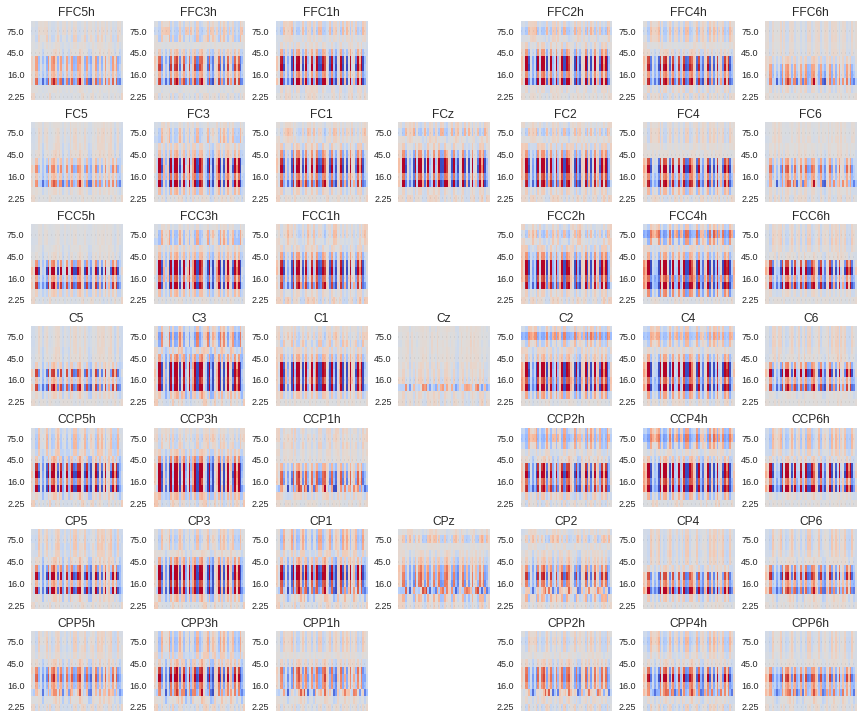

In [18]:
from braindecode.datasets.sensor_positions import (tight_C_positions,
                                                   tight_bci_comp_4_2a_positions,
                                                   get_bci_competition_iv_2a_sensors,
                                                   )
from braindecode.analysis.plot_util import plot_chan_matrices
from braindecode.datasets.sensor_positions import get_C_sensors_sorted
sensor_names = get_C_sensors_sorted()
sensor_map = tight_C_positions
fig = plot_chan_matrices(topo_corrs.transpose(0,2,1),
                        sensor_names, sensor_map=sensor_map,
                  colormap=cm.coolwarm,  figsize=(12,10), vmin=-0.5, vmax=0.5)
plt.yticks(np.arange(len(filterbands))[::3] + 0.5, np.mean(filterbands, axis=1)[::3])

for ax in fig.axes:
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(9)
plt.tight_layout()
None

## Repeat for earlier layer (conv3)

In [19]:
from braindecode.analysis.envelopes import transform_to_trial_env
i_layer = 15
# transform that outer part is list so you can freely delete parts inside called function
# and avoid memory problems
# Actually memorywise not needed here, but function expects it now
# To be able to reuse, here we actually create a shallow copy
env = [e for e in env_per_filterband] 
train_set = exp.dataset_provider.get_train_valid_test(exp.dataset)['train']
trial_env = transform_to_trial_env(env, model, i_layer, train_set,
                                   n_inputs_per_trial=n_inputs_per_trial)

from braindecode.veganlasagne.layer_util import compute_trial_acts
trial_acts = compute_trial_acts(model, i_layer, exp.iterator, train_set)

INFO:braindecode.analysis.envelopes:Computing meaned envelope...
INFO:braindecode.analysis.envelopes:Transforming to per trial...
INFO:braindecode.analysis.envelopes:Merging to one array...
INFO:braindecode.analysis.envelopes:Done...
INFO:braindecode.veganlasagne.layer_util:Create theano function...
INFO:braindecode.veganlasagne.layer_util:Compute activations...
INFO:braindecode.veganlasagne.layer_util:Transform to trial activations...
INFO:braindecode.veganlasagne.layer_util:Done.


In [20]:
from braindecode.analysis.envelopes import compute_topo_corrs

topo_corrs = compute_topo_corrs(trial_env, trial_acts)

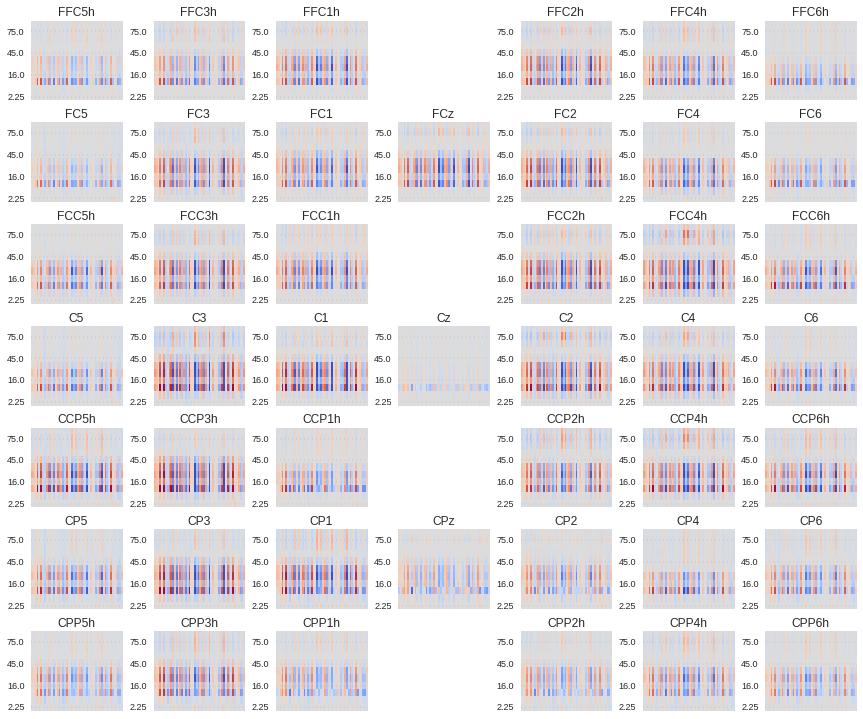

In [21]:
from braindecode.datasets.sensor_positions import (tight_C_positions,
                                                   tight_bci_comp_4_2a_positions,
                                                   get_bci_competition_iv_2a_sensors,
                                                   )
from braindecode.analysis.plot_util import plot_chan_matrices
from braindecode.datasets.sensor_positions import get_C_sensors_sorted
sensor_names = get_C_sensors_sorted()
sensor_map = tight_C_positions
fig = plot_chan_matrices(topo_corrs.transpose(0,2,1),
                        sensor_names, sensor_map=sensor_map,
                  colormap=cm.coolwarm,  figsize=(12,10), vmin=-0.5, vmax=0.5)
plt.yticks(np.arange(len(filterbands))[::3] + 0.5, np.mean(filterbands, axis=1)[::3])

for ax in fig.axes:
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(9)
plt.tight_layout()
None

## Repeat for earlier layer (conv2)

INFO:braindecode.analysis.envelopes:Computing meaned envelope...
INFO:braindecode.analysis.envelopes:Transforming to per trial...
INFO:braindecode.analysis.envelopes:Merging to one array...
INFO:braindecode.analysis.envelopes:Done...
INFO:braindecode.veganlasagne.layer_util:Create theano function...
INFO:braindecode.veganlasagne.layer_util:Compute activations...
INFO:braindecode.veganlasagne.layer_util:Transform to trial activations...
INFO:braindecode.veganlasagne.layer_util:Done.


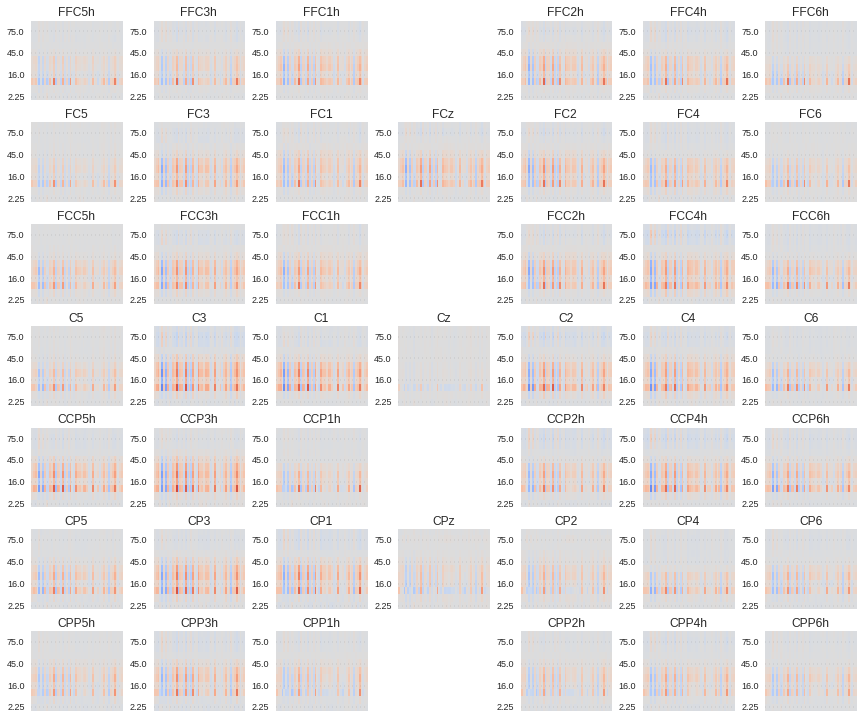

In [22]:
from braindecode.analysis.envelopes import transform_to_trial_env
i_layer = 10
# transform that outer part is list so you can freely delete parts inside called function
# and avoid memory problems
# Actually memorywise not needed here, but function expects it now
# To be able to reuse, here we actually create a shallow copy
env = [e for e in env_per_filterband] 
train_set = exp.dataset_provider.get_train_valid_test(exp.dataset)['train']
trial_env = transform_to_trial_env(env, model, i_layer, train_set,
                                   n_inputs_per_trial=n_inputs_per_trial)

from braindecode.veganlasagne.layer_util import compute_trial_acts
trial_acts = compute_trial_acts(model, i_layer, exp.iterator, train_set)

from braindecode.analysis.envelopes import compute_topo_corrs

topo_corrs = compute_topo_corrs(trial_env, trial_acts)

from braindecode.datasets.sensor_positions import (tight_C_positions,
                                                   tight_bci_comp_4_2a_positions,
                                                   get_bci_competition_iv_2a_sensors,
                                                   )
from braindecode.analysis.plot_util import plot_chan_matrices
from braindecode.datasets.sensor_positions import get_C_sensors_sorted
sensor_names = get_C_sensors_sorted()
sensor_map = tight_C_positions
fig = plot_chan_matrices(topo_corrs.transpose(0,2,1),
                        sensor_names, sensor_map=sensor_map,
                  colormap=cm.coolwarm,  figsize=(12,10), vmin=-0.5, vmax=0.5)
plt.yticks(np.arange(len(filterbands))[::3] + 0.5, np.mean(filterbands, axis=1)[::3])

for ax in fig.axes:
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(9)
plt.tight_layout()
None

## Repeat for earlier layer (conv1)

INFO:braindecode.analysis.envelopes:Computing meaned envelope...
INFO:braindecode.analysis.envelopes:Transforming to per trial...
INFO:braindecode.analysis.envelopes:Merging to one array...
INFO:braindecode.analysis.envelopes:Done...
INFO:braindecode.veganlasagne.layer_util:Create theano function...
INFO:braindecode.veganlasagne.layer_util:Compute activations...
INFO:braindecode.veganlasagne.layer_util:Transform to trial activations...
INFO:braindecode.veganlasagne.layer_util:Done.


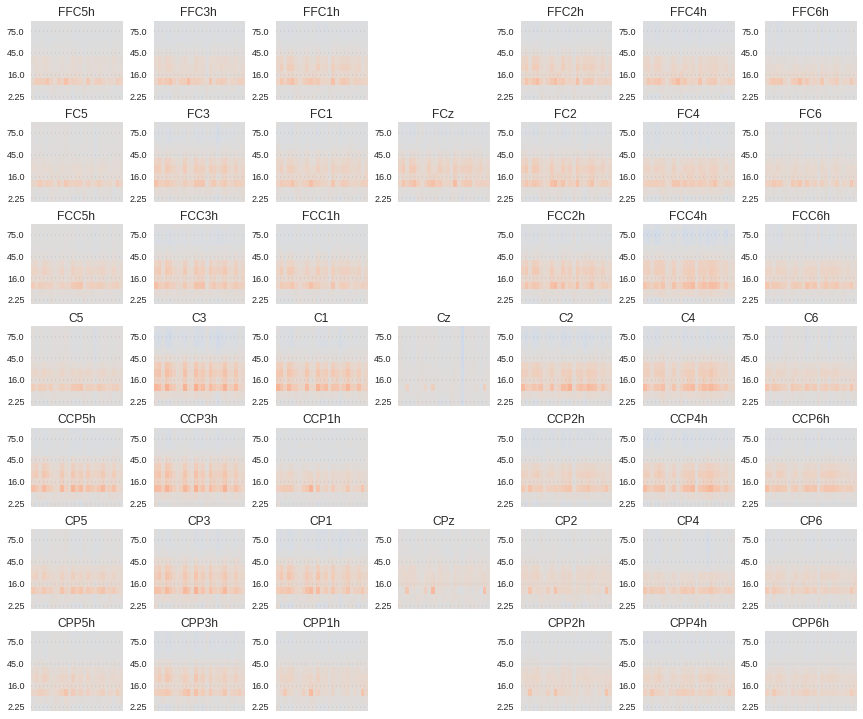

In [23]:
from braindecode.analysis.envelopes import transform_to_trial_env
i_layer = 5
# transform that outer part is list so you can freely delete parts inside called function
# and avoid memory problems
# Actually memorywise not needed here, but function expects it now
# To be able to reuse, here we actually create a shallow copy
env = [e for e in env_per_filterband] 
train_set = exp.dataset_provider.get_train_valid_test(exp.dataset)['train']
trial_env = transform_to_trial_env(env, model, i_layer, train_set,
                                   n_inputs_per_trial=n_inputs_per_trial)

from braindecode.veganlasagne.layer_util import compute_trial_acts
trial_acts = compute_trial_acts(model, i_layer, exp.iterator, train_set)

from braindecode.analysis.envelopes import compute_topo_corrs

topo_corrs = compute_topo_corrs(trial_env, trial_acts)

from braindecode.datasets.sensor_positions import (tight_C_positions,
                                                   tight_bci_comp_4_2a_positions,
                                                   get_bci_competition_iv_2a_sensors,
                                                   )
from braindecode.analysis.plot_util import plot_chan_matrices
from braindecode.datasets.sensor_positions import get_C_sensors_sorted
sensor_names = get_C_sensors_sorted()
sensor_map = tight_C_positions
fig = plot_chan_matrices(topo_corrs.transpose(0,2,1),
                        sensor_names, sensor_map=sensor_map,
                  colormap=cm.coolwarm,  figsize=(12,10), vmin=-0.5, vmax=0.5)
plt.yticks(np.arange(len(filterbands))[::3] + 0.5, np.mean(filterbands, axis=1)[::3])

for ax in fig.axes:
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(9)
plt.tight_layout()
None

### Before first nonlinearity

INFO:braindecode.analysis.envelopes:Computing meaned envelope...
INFO:braindecode.analysis.envelopes:Transforming to per trial...
INFO:braindecode.analysis.envelopes:Merging to one array...
INFO:braindecode.analysis.envelopes:Done...
INFO:braindecode.veganlasagne.layer_util:Create theano function...
INFO:braindecode.veganlasagne.layer_util:Compute activations...
INFO:braindecode.veganlasagne.layer_util:Transform to trial activations...
INFO:braindecode.veganlasagne.layer_util:Done.


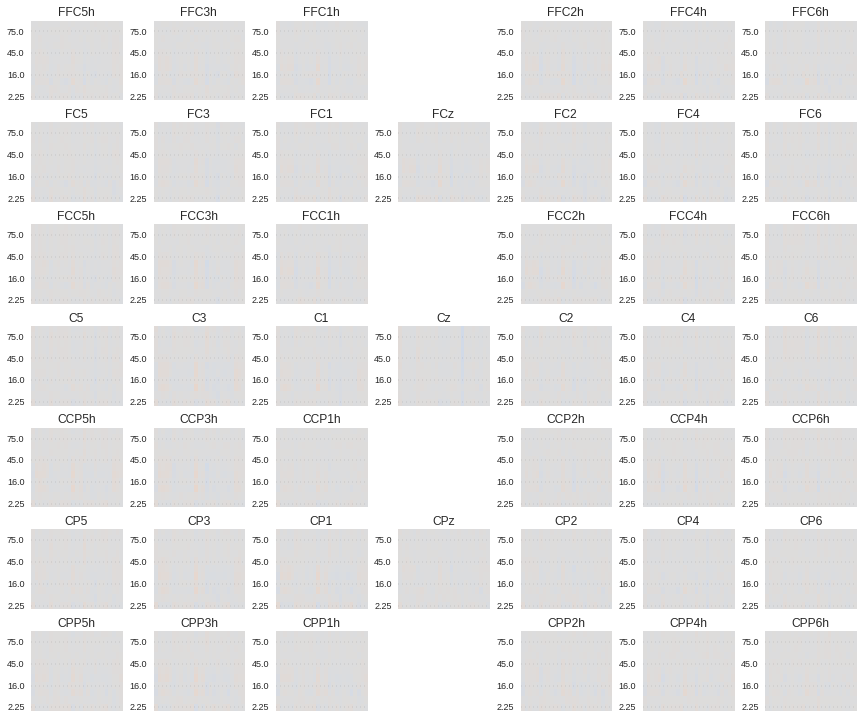

In [24]:
from braindecode.analysis.envelopes import transform_to_trial_env
i_layer = 4
# transform that outer part is list so you can freely delete parts inside called function
# and avoid memory problems
# Actually memorywise not needed here, but function expects it now
# To be able to reuse, here we actually create a shallow copy
env = [e for e in env_per_filterband] 
train_set = exp.dataset_provider.get_train_valid_test(exp.dataset)['train']
trial_env = transform_to_trial_env(env, model, i_layer, train_set,
                                   n_inputs_per_trial=n_inputs_per_trial)

from braindecode.veganlasagne.layer_util import compute_trial_acts
trial_acts = compute_trial_acts(model, i_layer, exp.iterator, train_set)

from braindecode.analysis.envelopes import compute_topo_corrs

topo_corrs = compute_topo_corrs(trial_env, trial_acts)

from braindecode.datasets.sensor_positions import (tight_C_positions,
                                                   tight_bci_comp_4_2a_positions,
                                                   get_bci_competition_iv_2a_sensors,
                                                   )
from braindecode.analysis.plot_util import plot_chan_matrices
from braindecode.datasets.sensor_positions import get_C_sensors_sorted
sensor_names = get_C_sensors_sorted()
sensor_map = tight_C_positions
fig = plot_chan_matrices(topo_corrs.transpose(0,2,1),
                        sensor_names, sensor_map=sensor_map,
                  colormap=cm.coolwarm,  figsize=(12,10), vmin=-0.5, vmax=0.5)
plt.yticks(np.arange(len(filterbands))[::3] + 0.5, np.mean(filterbands, axis=1)[::3])

for ax in fig.axes:
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(9)
plt.tight_layout()
None

## Stuff for me

In [1]:
%%capture
import scikits.samplerate
import sklearn
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
#os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'
%load_ext autoreload
%autoreload 2